### <strong>POPQUORN</strong>
<strong>Po</strong>tato-<strong>P</strong>rolific dataset for <strong>Qu</strong>estion-Answering, <strong>O</strong>ffensiveness, text <strong>R</strong>ewriting and politeness rating with demographic <strong>N</strong>uance

[Source](https://github.com/Jiaxin-Pei/potato-prolific-dataset)
___

Comprises <strong>four NLP tasks</strong>:
1. Offensiveness rating
2. Question Answering
3. Text rewriting / Style transfer
4. Politeness rating

### <strong>3.</strong> Email Rewriting

* Data is taken from [Enron](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset) dataset
    * Contains around `500k` emails from the Enron Corporation
* Emails in POPQUORN
    * only consist of their main body
    * are between `8` and `100` words in length
    * contain no URLs and few numbers
    * used [Politenessr](https://github.com/wujunjie1998/Politenessr) to infer initial politeness scores (`1-5`)
        * sampled `1000 (?)` emails, `50%` from `(1,3)`, `40%` from `(3,4)` and `10%` from `(4,5)`
* Annotators were
    * drawn from US-population representative sample regarding sociodem. attributes (from [Prolific](https://www.prolific.com/))
    * given `10` emails and asked to "rewrite the email to make it sound more polite in a work setting"
* Revised emails must be at least `7` words long and have an edit distance of at least `5` to be kept in
* Analysis and findings
    * Overall, politeness increased by `0.27` on average
    * No connections to annotator backgrounds drawn

In [1]:
from IPython.display import display, HTML
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import json
import os

%matplotlib inline

In [2]:
path_to_dirs = '../../../data/Potato-Prolific-Dataset/dataset'
file_name = 'raw_data.csv'
sample_size=10

In [3]:
path_to_data = f'{path_to_dirs}/email_rewriting/{file_name}'

df = pd.read_csv(path_to_data)
df

,instance_id,user_id,original email,revised email,gender,race,age,occupation,education
0,788,NaN,yes. you need to come over more.,Absolutely. You should consider coming over m...,NaN,NaN,NaN,NaN,NaN
1,861,NaN,MAKE SURE YOU TURN UP YOUR MUSIC..\n> \n> \n...,Ensure your music is turned up.,NaN,NaN,NaN,NaN,NaN
2,82,NaN,"Shelley, FYI. Raetta is working closely with ...","Shelley, there are a number of us who will be ...",NaN,NaN,NaN,NaN,NaN
3,1444,0.0,Which award are you going for? the Skankiest ...,"Hey,\r\nWhich award are you going for? I would...",Woman,White,NaN,Student,High school diploma or equivalent
4,1064,0.0,All of a sudden Mark Frevert asks me everyday ...,"Hello,\r\nMark Frevery has been asking me abou...",Woman,White,NaN,Student,High school diploma or equivalent
...,...,...,...,...,...,...,...,...,...
2341,296,229.0,This year may be more fun. We are very thin a...,This year may be more fun. We are very lean an...,Man,Asian,NaN,Self-employed,Graduate degree
2342,4,229.0,Attached is the Weekly Report for ETS Planning...,Attached is the Weekly Report for ETS Planning...,Man,Asian,NaN,Self-employed,Graduate degree
2343,6,229.0,See the attached revision for the Peoples CA. ...,Please see the attached revision for the Peopl...,Man,Asian,NaN,Self-employed,Graduate degree
2344,1088,229.0,Ad valorems do not necessarily decrease as a r...,Ad valorems do not necessarily decrease as a r...,Man,Asian,NaN,Self-employed,Graduate degree


### 3.1 General stats

In [4]:
meta_cols = list(df.columns[df.columns.get_loc('gender'):])
df_users = df[meta_cols].drop_duplicates()
df_users

,gender,race,age,occupation,education
0,NaN,NaN,NaN,NaN,NaN
3,Woman,White,NaN,Student,High school diploma or equivalent
13,Man,White,NaN,Prefer not to disclose,Less than a high school diploma
23,Woman,Biracial,NaN,Employed,Graduate degree
34,Woman,White,NaN,Self-employed,College degree
...,...,...,...,...,...
2172,Man,Indigenous American,NaN,Self-employed,College degree
2195,Woman,White,NaN,Unemployed,Graduate degree
2225,Non-binary,Hispanic or Latino,NaN,Employed,College degree
2266,Man,Asian,NaN,Employed,Graduate degree


In [5]:
# Number of instances, number of annotators

num_inst = df['instance_id'].nunique()
num_annotr = 257 # value taken from the paper, as user_ids are only partially given

print(f"Number of instances: {num_inst}")
print(f"Number of annotators: {num_annotr} (paper)")

Number of instances: 1429
Number of annotators: 257 (paper)


In [6]:
# Number of annotations per instance

num_annotn_per_inst = df.groupby('instance_id').size()
print(f"Number of annotations per instance:\n{num_annotn_per_inst.mean():.2f} MEAN, {num_annotn_per_inst.std():.2f} STD")
print(f"Fewest annotations: {num_annotn_per_inst.min()}")
print(f"Most annotations: {num_annotn_per_inst.max()}")

Number of annotations per instance:
1.64 MEAN, 0.48 STD
Fewest annotations: 1
Most annotations: 2


In [7]:
# Instance text (original email) lengths

inst_texts = df['original email'].unique()
inst_text_lengths_char = [len(text) for text in inst_texts]
inst_text_lengths = [len(text.split()) for text in inst_texts]

print(f"Instance text lengths (chars):\n{np.mean(inst_text_lengths_char):.2f} MEAN, {np.std(inst_text_lengths_char):.2f} STD")
print(f"Instance text lengths (words):\n{np.mean(inst_text_lengths):.2f} MEAN, {np.std(inst_text_lengths):.2f} STD")

Instance text lengths (chars):
169.61 MEAN, 124.49 STD
Instance text lengths (words):
31.07 MEAN, 21.80 STD


In [8]:
# Instance answer (revised email) lengths

inst_answers = df['revised email'].unique()
inst_answer_lengths_char = [len(q) for q in inst_answers]
inst_answer_lengths = [len(q.split()) for q in inst_answers]

print(f"Instance answer lengths (chars):\n{np.mean(inst_answer_lengths_char):.2f} MEAN, {np.std(inst_answer_lengths_char):.2f} STD")
print(f"Instance answer lengths (words):\n{np.mean(inst_answer_lengths):.2f} MEAN, {np.std(inst_answer_lengths):.2f} STD")

Instance answer lengths (chars):
195.78 MEAN, 142.88 STD
Instance answer lengths (words):
35.66 MEAN, 24.91 STD


In [9]:
# NaN entries

num_nan = df.isna().sum().sum()

print(f"Number of NaN entries: {num_nan}")
print(df.isna().sum())

Number of NaN entries: 2746
instance_id          0
user_id             80
original email       0
revised email        0
gender              80
race                80
age               2346
occupation          80
education           80
dtype: int64


### 3.2 Sociodemographic information

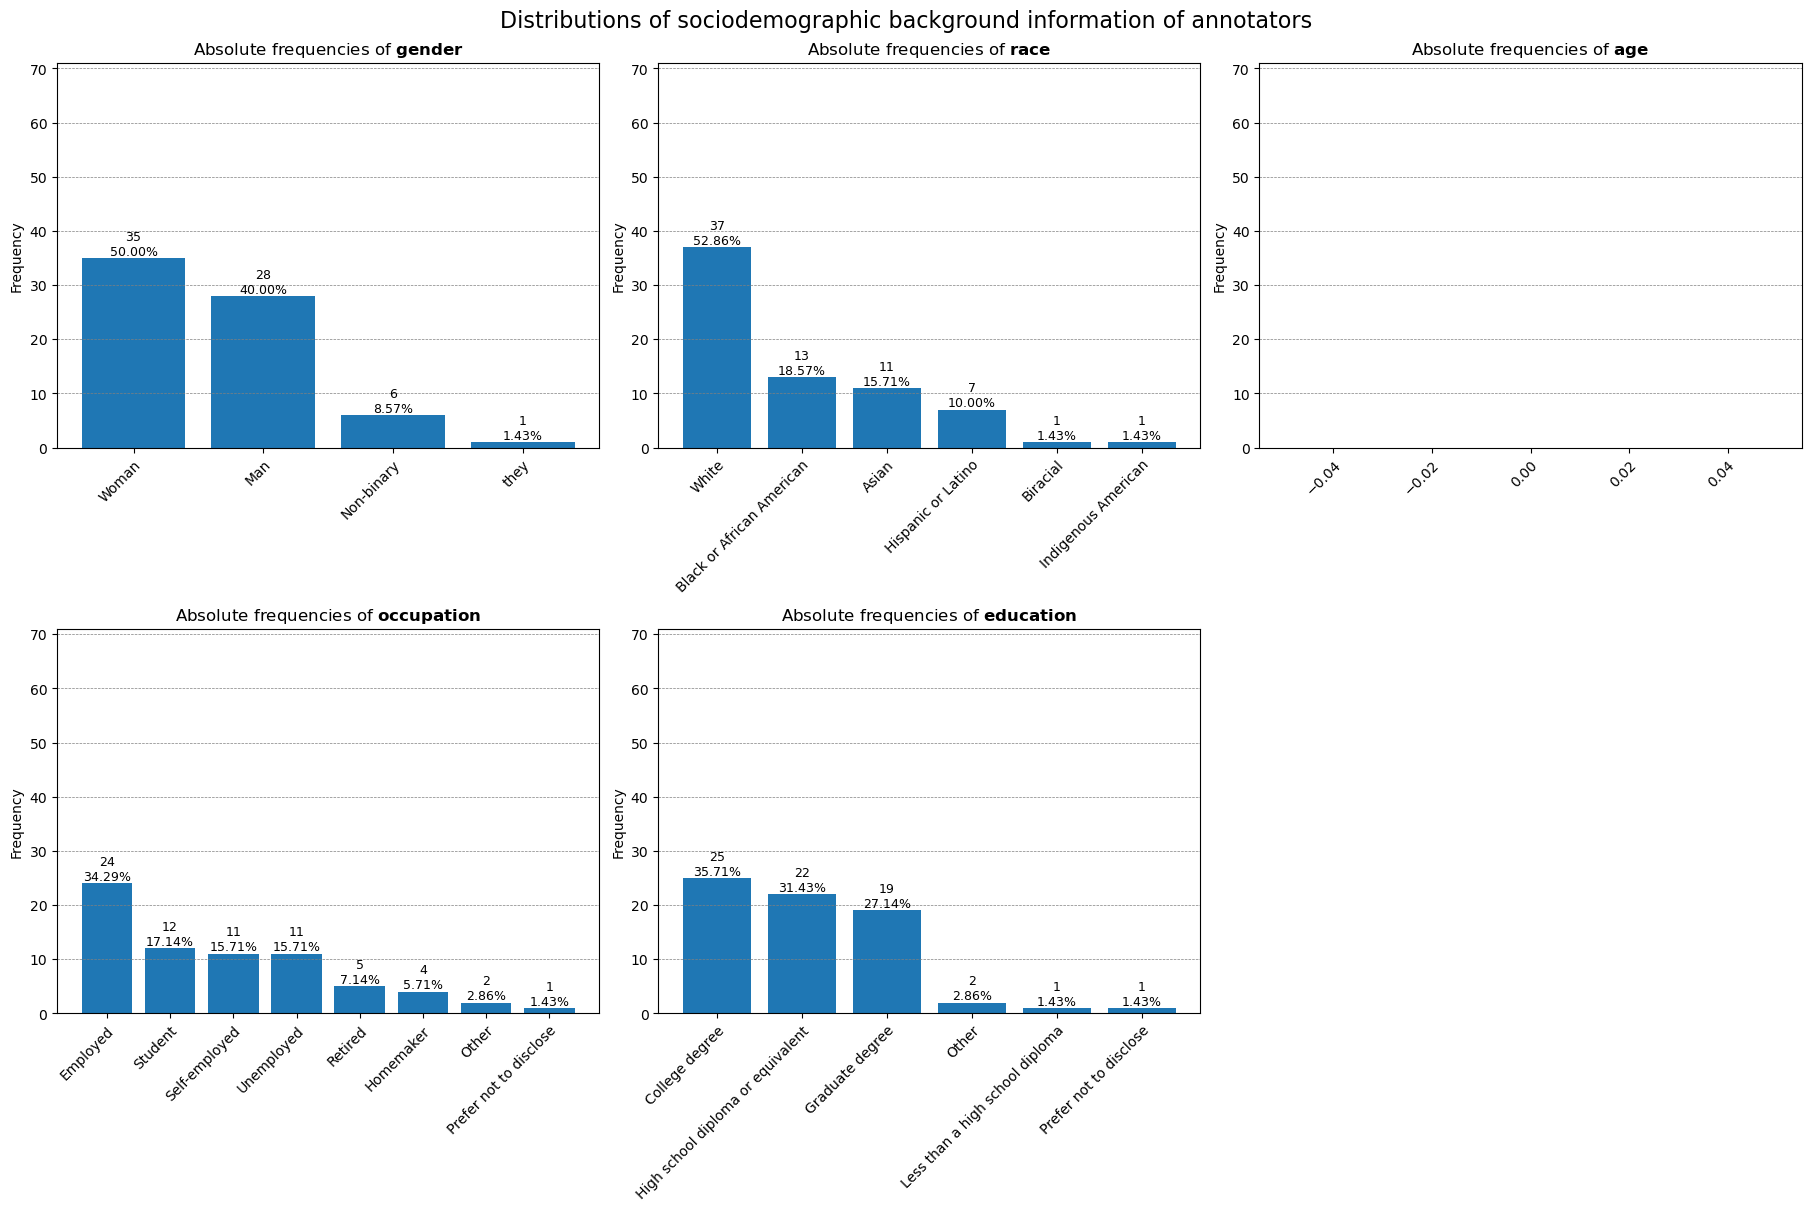

In [10]:
# track the frequencies of each sociodemographic attribute's values
meta_dict = {attr: None for attr in df_users.columns}

fig, axes = plt.subplots(2, 3, figsize=(18,12), constrained_layout=True)
fig.suptitle("Distributions of sociodemographic background information of annotators", fontsize=16)
axes = axes.flatten()
axes[5].axis('off') # remove unused sixth subplot

l = df_users.columns.get_loc('gender')
for i, column in enumerate(df_users.columns[l:]):
    
    abs_freqs = df_users[column].value_counts()
    rel_freqs = df_users[column].value_counts(normalize=True)
  
    bars = axes[i].bar(abs_freqs.index, abs_freqs.values)
    axes[i].set_title(rf"Absolute frequencies of $\bf{{{column}}}$")
    axes[i].set_ylabel("Frequency")
    axes[i].set_ylim(0, len(df_users))
    
    meta_dict[column] = dict(map(lambda i,j : (i,j) , rel_freqs.index, rel_freqs.values))
    
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_rotation_mode('anchor')

    # label the bars with the absolute and relative frequency values
    for bar, abs_freq, rel_freq in zip(bars, abs_freqs, rel_freqs):
        # save the frequencies for later
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{abs_freq}\n{rel_freq*100:.2f}%',
            ha='center',
            va='bottom',
            fontsize=9)    
    
    # add horizontal lines
    for y in axes[i].get_yticks():
        axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
        
plt.show()